# **Importing** **Necessary** **Libaries** **bold text**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dropout,Dense
import seaborn as sns

In [ ]:
abuad_data_dir = "/content/drive/MyDrive/Abuad signature dataset"

# Load the dataset with automatic class inference from subdirectories
train_ds = tf.keras.utils.image_dataset_from_directory(
    abuad_data_dir,
    validation_split= 0.1,
    subset= 'training',
    seed= 12,
    image_size=(150,150),

)

Found 936 files belonging to 2 classes.
Using 843 files for training.


In [ ]:

# Load the dataset with automatic class inference from subdirectories
validation_ds = tf.keras.utils.image_dataset_from_directory(
    abuad_data_dir,
    validation_split= 0.1,
    subset= 'validation',
    seed= 12,
    image_size=(150,150),

)

Found 936 files belonging to 2 classes.
Using 93 files for validation.


In [ ]:
testing_dir = "/content/drive/MyDrive/Testt_set"

test_ds = tf.keras.utils.image_dataset_from_directory(
    testing_dir,
    image_size=(150,150),

)

Found 104 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names

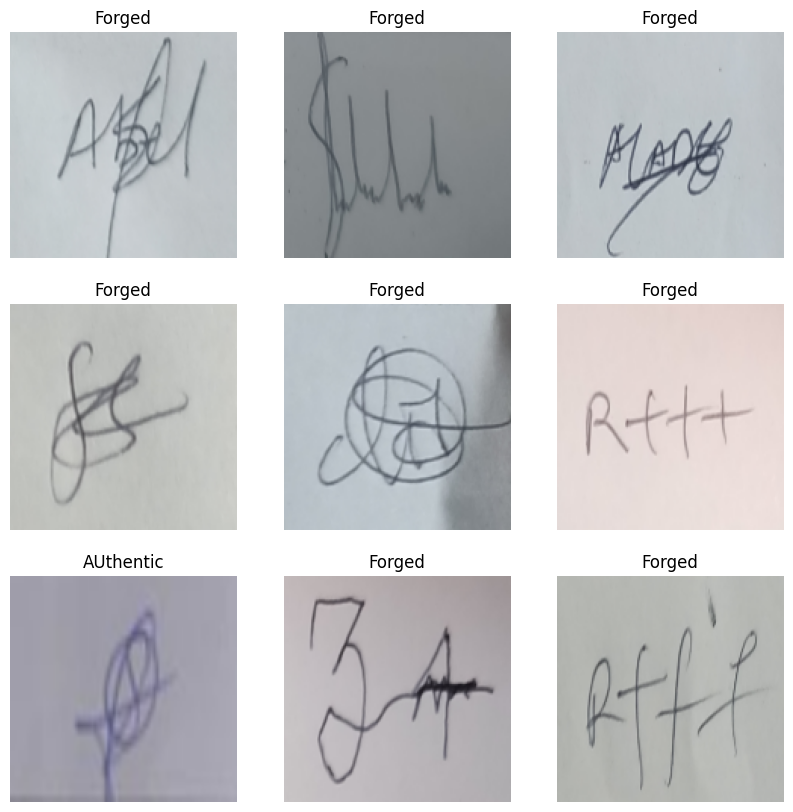

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))



In [ ]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]
print(images.shape)

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x
print(images.shape)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
print(images.shape)


(32, 150, 150, 3)
(32, 150, 150, 3)
(32, 150, 150, 3)


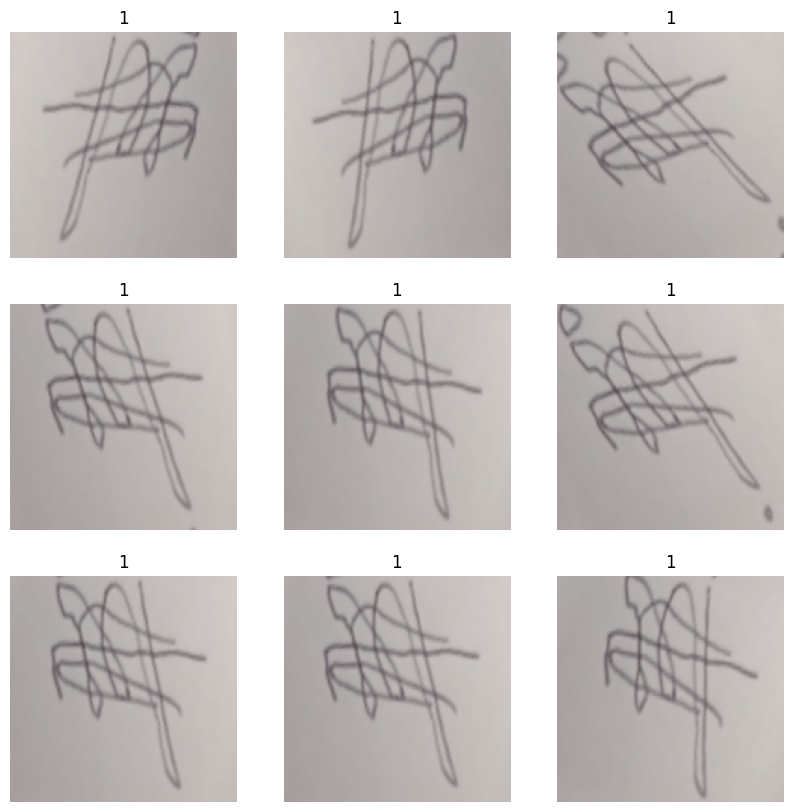

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
# for images, labels in train_ds.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = images[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(np.expand_dims(first_image, 0))
#         plt.imshow(np.array(augmented_image[0]).astype("int32"))
#         plt.title(int(labels[0]))
#         plt.axis("off")

# **Calling The Xception model**

In [ ]:
xception_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)
xception_model.trainable = False


inputs = keras.Input(shape=(150, 150, 3))

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)


x = xception_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
first_model = keras.Model(inputs, outputs)

first_model.summary(show_trainable=True)

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                         

In [ ]:

first_model.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=[keras.metrics.BinaryAccuracy()])
epochs = 2
print("Fitting the top layer of the model")
first_model.fit(train_ds, epochs=epochs,)

Fitting the top layer of the model
Epoch 1/2
27/27 [==============================] - 70s 2s/step - loss: 1.5400 - binary_accuracy: 0.6358
Epoch 2/2
27/27 [==============================] - 4s 131ms/step - loss: 0.6504 - binary_accuracy: 0.8161


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
xception_model.trainable = True
first_model.summary(show_trainable=True)

first_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),

    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(),keras.metrics.Precision(),keras.metrics.Recall()],
                           )

epochs = 1
print("Fitting the end-to-end model")
history=first_model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
print("Test dataset evaluation")
first_model.evaluate(test_ds)


Test dataset evaluation
4/4 [==============================] - 25s 428ms/step - loss: 2.1765 - binary_accuracy: 0.5577 - true_positives: 35.0000 - true_negatives: 23.0000 - false_positives: 29.0000 - false_negatives: 17.0000 - precision: 0.5469 - recall: 0.6731


[2.1765055656433105,
 0.557692289352417,
 35.0,
 23.0,
 29.0,
 17.0,
 0.546875,
 0.6730769276618958]

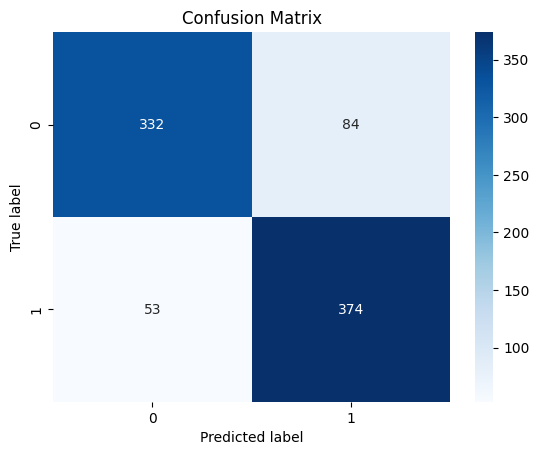

In [ ]:

tp = 374
fn = 53
tn = 332
fp = 84

# Create confusion matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Squeeze the confusion matrix
conf_matrix = np.squeeze(conf_matrix)

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')  # Creates a heatmap visualization with annotations
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()  # Displays the heatmap



In [ ]:
resnet50_model = keras.applications.ResNet101(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
resnet50_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = resnet50_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
second_model = keras.Model(inputs, outputs)

second_model.summary(show_trainable=True)

171446536/171446536 [==============================] - 1s 0us/step
Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 resnet101 (Functional)      (None, 5, 5, 2048)        4265817   N          
                                                       6                    
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                     

In [ ]:

second_model.compile(optimizer='rmsprop', loss='binary_crossentropy',
               metrics=[keras.metrics.BinaryAccuracy()])
epochs = 2
print("Fitting the top layer of the model")
second_model.fit(train_ds, epochs=epochs,)

Fitting the top layer of the model
Epoch 1/2
27/27 [==============================] - 16s 184ms/step - loss: 1.5165 - binary_accuracy: 0.5291
Epoch 2/2
27/27 [==============================] - 9s 320ms/step - loss: 0.7869 - binary_accuracy: 0.5872


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
resnet50_model.trainable = True
second_model.summary(show_trainable=True)

second_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),

    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(),keras.metrics.Precision(),keras.metrics.Recall()],
                           )

epochs = 1
print("Fitting the end-to-end model")
history=second_model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 resnet101 (Functional)      (None, 5, 5, 2048)        4265817   Y          
                                                       6                    
                                                                            
 global_average_pooling2d_1  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 2048)              0   

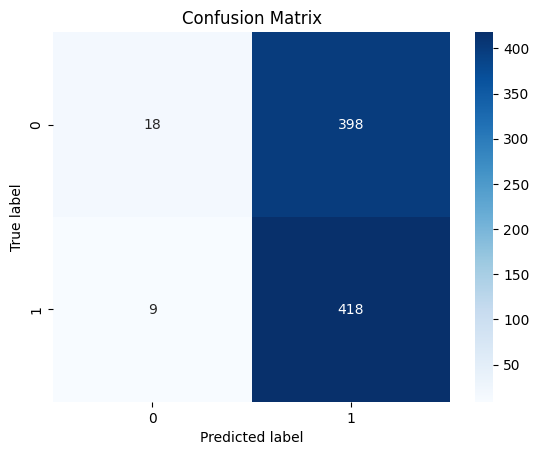

In [ ]:

tp = 418
fn = 9
tn = 18
fp = 398

# Create confusion matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Squeeze the confusion matrix
conf_matrix = np.squeeze(conf_matrix)

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')  # Creates a heatmap visualization with annotations
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()  # Displays the heatmap



In [ ]:
print("Test dataset evaluation")
second_model.evaluate(test_ds)


Test dataset evaluation
4/4 [==============================] - 1s 349ms/step - loss: 7.6246 - binary_accuracy: 0.5000 - true_positives_1: 52.0000 - true_negatives_1: 0.0000e+00 - false_positives_1: 52.0000 - false_negatives_1: 0.0000e+00 - precision_1: 0.5000 - recall_1: 1.0000


[7.624619483947754, 0.5, 52.0, 0.0, 52.0, 0.0, 0.5, 1.0]

In [ ]:
Densenet121_model = keras.applications.DenseNet121(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
Densenet121_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = Densenet121_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
third_model = keras.Model(inputs, outputs)

third_model.summary(show_trainable=True)

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   N          
                                                                            
 global_average_pooling2d_2  (None, 1024)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 1024)              0         Y     

In [ ]:

third_model.compile(optimizer='rmsprop', loss='binary_crossentropy',
               metrics=[keras.metrics.BinaryAccuracy()])
epochs = 2
print("Fitting the top layer of the model")
third_model.fit(train_ds, epochs=epochs,)

Fitting the top layer of the model
Epoch 1/2
27/27 [==============================] - 17s 238ms/step - loss: 4.8019 - binary_accuracy: 0.4745
Epoch 2/2
27/27 [==============================] - 4s 132ms/step - loss: 4.2062 - binary_accuracy: 0.5433


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
Densenet121_model.trainable = True
third_model.summary(show_trainable=True)

third_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),

    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(),keras.metrics.Precision(),keras.metrics.Recall()],
                           )

epochs = 5
print("Fitting the end-to-end model")
history=third_model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   Y          
                                                                            
 global_average_pooling2d_2  (None, 1024)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 1024)              0         Y          
                                                           

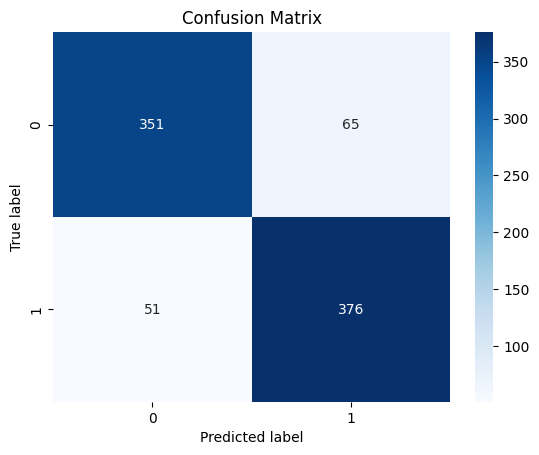

In [ ]:

tp = 376
fn = 51
tn = 351
fp = 65

# Create confusion matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Squeeze the confusion matrix
conf_matrix = np.squeeze(conf_matrix)

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')  # Creates a heatmap visualization with annotations
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()  # Displays the heatmap



In [ ]:
print("Test dataset evaluation")
third_model.evaluate(test_ds)


Test dataset evaluation
4/4 [==============================] - 3s 752ms/step - loss: 3.8095 - binary_accuracy: 0.5288 - true_positives_2: 48.0000 - true_negatives_2: 7.0000 - false_positives_2: 45.0000 - false_negatives_2: 4.0000 - precision_2: 0.5161 - recall_2: 0.9231


[3.809547185897827,
 0.5288461446762085,
 48.0,
 7.0,
 45.0,
 4.0,
 0.5161290168762207,
 0.9230769276618958]

In [ ]:
mobilenetv2_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
mobilenetv2_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = mobilenetv2_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
fourth_model = keras.Model(inputs, outputs)

fourth_model.summary(show_trainable=True)

Model: "model_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d_4  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_4 (Dropout)         (None, 1280)              0   

In [ ]:

fourth_model.compile(optimizer='rmsprop', loss='binary_crossentropy',
               metrics=[keras.metrics.BinaryAccuracy()])
epochs = 2
print("Fitting the top layer of the model")
fourth_model.fit(train_ds, epochs=epochs,)

Fitting the top layer of the model
Epoch 1/2
27/27 [==============================] - 7s 106ms/step - loss: 6.2431 - binary_accuracy: 0.4508
Epoch 2/2
27/27 [==============================] - 4s 114ms/step - loss: 4.8168 - binary_accuracy: 0.5552


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
mobilenetv2_model.trainable = True
fourth_model.summary(show_trainable=True)

fourth_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),

    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(),keras.metrics.Precision(),keras.metrics.Recall()],
                           )

epochs = 1
print("Fitting the end-to-end model")
history=fourth_model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d_4  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_4 (Dropout)         (None, 1280)              0   

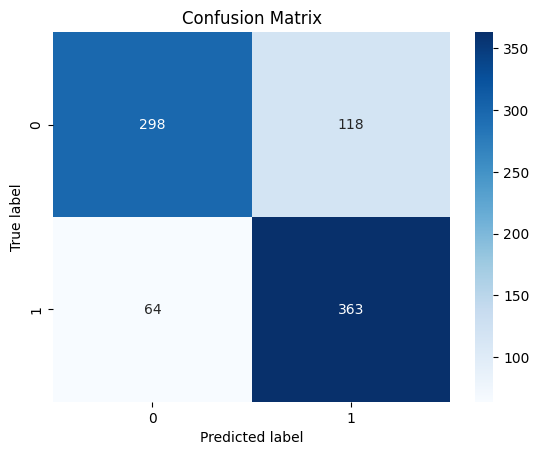

In [ ]:

tp = 363
fn = 64
tn = 298
fp = 118

# Create confusion matrix
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Squeeze the confusion matrix
conf_matrix = np.squeeze(conf_matrix)

# Plot confusion matrix as heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')  # Creates a heatmap visualization with annotations
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()  # Displays the heatmap



In [ ]:
print("Test dataset evaluation")
fourth_model.evaluate(test_ds)


Test dataset evaluation
4/4 [==============================] - 1s 33ms/step - loss: 6.4557 - binary_accuracy: 0.5288 - true_positives_4: 48.0000 - true_negatives_4: 7.0000 - false_positives_4: 45.0000 - false_negatives_4: 4.0000 - precision_4: 0.5161 - recall_4: 0.9231


[6.455685138702393,
 0.5288461446762085,
 48.0,
 7.0,
 45.0,
 4.0,
 0.5161290168762207,
 0.9230769276618958]

In [ ]:
my_model=model.save('my_model.h5')


In [ ]:
pred=model.predict(test_ds)

In [ ]:
threshold = 0.5  # You can adjust this based on your needs

# Apply the threshold to classify samples
y_pred_binary = (pred > threshold).astype(int)

# Print the shapes of predictions and binary predictions
print(y_pred_binary)

In [ ]:
from keras.models import load_model

loaded_model = load_model('my_model.h5')  # Assuming HDF5 format


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
Input_imagee = Image.open('/content/drive/Othercomputers/My Laptop/signatures/full_forg/forgeries_10_10.png')
plt.imshow(Input_imagee)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the image
img = load_img(input('input path'), target_size=(150, 150))

# Convert to NumPy array
image_array = img_to_array(img)


# Reshape if necessary (depends on your model's input shape)
image_array = np.expand_dims(image_array, axis=0)  # Add a batch dimension

# Now you can use image_array for prediction
prediction = model.predict(image_array,verbose=1)
prediction


In [ ]:
img_pred=tf.keras.utils.load_img(
    '/content/drive/Othercomputers/My Laptop/signatures/full_forg/forgeries_10_10.png',
    grayscale=False,
    color_mode='rgb',
    target_size=(150,150)
)
plt.imshow(img_pred)

In [ ]:
image_array=tf.keras.utils.img_to_array(
    img_pred, data_format=None, dtype=None
)
image_array.shape

In [ ]:
compart_img=np.expand_dims(image_array,axis=0)
compart_img.shape

In [ ]:
pred= model.predict(compart_img)

In [ ]:
pred